In [107]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

### use vgg19 to extract sketch features

In [108]:
def deactivate(net):
    net.eval()
    for p in net.parameters():
        p.requires_grad = False  
        
use_cuda = torch.cuda.is_available()
cuda_device = 0

vgg19 = models.vgg19(pretrained=True).cuda(cuda_device)
vgg19_features = deepcopy(vgg19.features)
vgg19_classifier = deepcopy(vgg19.classifier)

# remove last layer of classifier
vgg19_classifier = nn.Sequential(*(list(vgg19_classifier.children())[:-1]))

if use_cuda:
    vgg19_features.cuda(cuda_device)
    vgg19_classifier.cuda(cuda_device)

deactivate(vgg19_features)
deactivate(vgg19_classifier)

### get EXPERIMENTAL sketch data and metadata

In [326]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[1]

# extract metadata
path_to_sketches = 'sketches'
sketch_paths = sorted(list_files(path_to_sketches))
labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)

# augment with additional metadata from each subject's metadata file
sub_dirs = [i for i in sorted(os.listdir('sketches')) if i[-11:]=='neurosketch']
path_to_sub_meta = [os.path.join(path_to_sketches,s,s+'_metadata.csv') for s in sub_dirs]

# concatenate all subjects' metadata files
Y = []
for p in path_to_sub_meta:
    _Y = pd.read_csv(p)
    if len(Y)==0:
        Y = _Y
    else:
        Y = pd.concat([Y,_Y],ignore_index=True)
        
# validate that the order is the same in the supersubject metadata file (Y) and the lists generated from sketch_paths        
subs = list(Y.wID.values)
merged = zip(subj,subs)
assert len([(i,j) for (i,j) in merged if i != j])==0        

competitors = list(Y.competitor.values)
version = list(Y.version.values)
viewpoint = list(Y.viewpoint.values)

objpose = [i+str(j) for (i,j) in zip(list(labels),list(viewpoint))]

# organize into dataframe
X = pd.DataFrame([subj,trialNum,labels,competitors,version,viewpoint,sketch_paths,objpose])
X = X.transpose()
X.columns = ['subj','trial','label','competitor','version','viewpoint','path','objpose']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))

num_sketches = len(sketch_paths)

Number of sketches: 1400
Number of subjects: 35


In [335]:
path_to_baselines = 'baseline_sketches'
baseline_paths = sorted(list_files(path_to_baselines))
def get_label_from_baseline_path(path):
    return path.split('/')[-1].split('_')[0]
def get_view_from_baseline_path(path):
    return path.split('/')[-1].split('_')[1]

baseline_labels = map(get_label_from_baseline_path,path_to_baselines)
baseline_views = map(get_view_from_baseline_path,path_to_baselines)

B = pd.read_csv('baseline_sketches/baseline_sketches_metadata.csv')

IndexError: list index out of range

'bed'

'0'

In [110]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def sketch_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        sketch = load_image(path)
        label = get_label_from_path(path)
        yield (sketch, label)

# define generator
generator = sketch_generator(sketch_paths,imsize=224,use_cuda=use_cuda)

# initialize sketch and label matrices
Features = []
Labels = []
n = 0
quit = False 

# generate batches of sketches and labels    
if generator:
    while True:    
        batch_size = 64
        sketch_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
        if use_cuda:
            sketch_batch = sketch_batch.cuda(cuda_device)                
        label_batch = []   
        print('Batch {}'.format(n + 1))            
        for b in range(batch_size):
            try:
                sketch, label = generator.next()
                sketch_batch[b] = sketch   
                label_batch.append(label)
            except StopIteration:
                quit = True
                print 'stopped!'
                break                
            
        if n == num_sketches//batch_size:
            sketch_batch = sketch_batch.narrow(0,0,b)
            label_batch = label_batch[:b + 1] 
        n = n + 1       

        # extract features from batch
        sketch_batch = vgg19_features(sketch_batch) 
        sketch_batch = sketch_batch.view(sketch_batch.size(0), -1)
        sketch_batch = vgg19_classifier(sketch_batch)
        sketch_batch = sketch_batch.cpu().data.numpy()

        if len(Features)==0:
            Features = sketch_batch
        else:
            Features = np.vstack((Features,sketch_batch))
        Labels.append(label_batch)

        if n == num_sketches//batch_size + 1:
            break
Labels = np.array([item for sublist in Labels for item in sublist])

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
stopped!


### Visualize feature similarity matrices

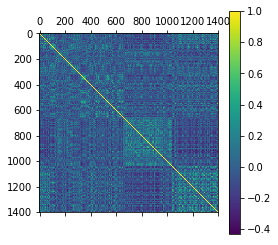

In [295]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

# normalize feature vectors & plot full image-level similarity matrix
_X = X.sort_values(['label','viewpoint','subj'])
inds = np.array(_X.index)
_Features = normalize(Features[inds])
_Labels = Labels[inds]
plt.matshow(np.corrcoef(_Features))
plt.colorbar()

In [296]:
def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu


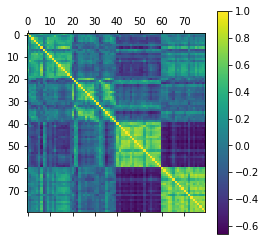

In [297]:
# plot OBJPOSE-level similarity matrix -- sorted by object and pose
views = _X.objpose.values
means = get_class_means(_Features, views)
plt.matshow(np.corrcoef(means))
plt.colorbar()

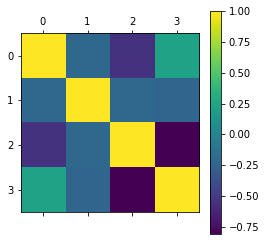

In [298]:
# plot category-level similarity matrix
means = get_class_means(Features, Labels)
plt.matshow(np.corrcoef(means))
plt.colorbar()

### Softmax classifier test

In [299]:
FEAT = _Features
LABELS = _Labels
# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)
run_this = 0
if run_this:
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [300]:
# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

0.889285714286


### Set up test for early vs. late in training

In [301]:
first_trial = int(min(X.trial))
last_trial = int(max(X.trial))
num_trials = last_trial-first_trial+1

In [322]:
## split up by first vs. second half of training phase
first_half = np.arange(first_trial,last_trial-num_trials/2+1)
second_half = np.arange(last_trial-num_trials/2+1,last_trial+1)

inds1 = _X['trial']<str(max(first_half))
inds2 = _X['trial']>=str(max(first_half))

X1 = _X[inds1]
X2 = _X[inds2]
assert len(X1)==len(X2)

FEAT1 = _Features[inds1]
FEAT2 = _Features[inds2]

LABELS1 = _Labels[inds1]
LABELS2 = _Labels[inds2]

clf = linear_model.LogisticRegression(penalty='l2')
print("Now fitting first half...")
scores = cross_val_score(clf, FEAT1, LABELS1, cv=12)
print("Accuracy on first half: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Now fitting second half...")
scores = cross_val_score(clf, FEAT2, LABELS2, cv=12)
print("Accuracy on second half: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Now fitting first half...
Accuracy on first half: 0.86 (+/- 0.09)
Now fitting second half...
Accuracy on second half: 0.88 (+/- 0.07)


In [303]:
_combos = [i+'_'+j for (i,j) in zip(list(_X.label.values),list(_X.competitor.values))]
lookup = {'bed_bench':'bed_bench',
          'bench_bed':'bed_bench',
          'bed_chair':'bed_chair',
          'chair_bed':'bed_chair',
          'bed_table':'bed_table',
          'table_bed':'bed_table',
          'bench_chair':'bench_chair',
          'chair_bench':'bench_chair',
          'bench_table':'bench_table',
          'table_bench':'bench_table',
          'chair_table':'chair_table',
          'table_chair':'chair_table',          
         }
axis = [lookup[c] for c in _combos]
unique_axes = np.unique(axis)

In [304]:
_X = _X.assign(axis=pd.Series(axis).values)

In [305]:
unique_axes

array(['bed_bench', 'bed_chair', 'bed_table', 'bench_chair', 'bench_table',
       'chair_table'],
      dtype='|S11')

In [306]:
inds_bed_bench = _X.axis=='bed_bench'
inds_bed_chair = _X.axis=='bed_chair'
inds_bed_table = _X.axis=='bed_table'
inds_bench_chair = _X.axis=='bench_chair'
inds_bench_table = _X.axis=='bench_table'
inds_chair_table = _X.axis=='chair_table'

In [307]:
def subset_feats(X,Features,axis,epoch):
    '''
    X = metadata dataframe
    Features = feature matrix
    axis = which object pair is trained, e.g. 'bed_bench'
    epoch = 'early' if first half, 'late' if second half, or 'all'
    
    '''
    if epoch=='early':
        inds = (X.axis==axis) & (X['trial']<str(max(first_half)))
    elif epoch=='late':
        inds = (X.axis==axis) & (X['trial']>=str(max(first_half)))
    elif epoch=='all':
        inds = (X.axis==axis)
    _X = X[inds]
    labels = list(_X.label.values)
    _Features = Features[inds]
    return _X, labels, _Features
    

In [321]:
Early = []
Late = []

for a in list(unique_axes):

    which_axis = a

    X1,L1,F1 = subset_feats(_X,_Features,which_axis,'early')
    clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1)
    scores = cross_val_score(clf, F1, L1, cv=12)
    print("Accuracy {} early: {} (+/- {})".format(which_axis, scores.mean(), scores.std() * 2))
    Early.append(scores.mean())

    X2,L2,F2 = subset_feats(_X,_Features,which_axis,'late')
    clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1)
    scores = cross_val_score(clf, F2, L2, cv=12)
    print("Accuracy {} late: {} (+/- {})".format(which_axis, scores.mean(), scores.std() * 2))
    Late.append(scores.mean())

    print ' '

Accuracy bed_bench early: 0.774305555556 (+/- 0.37338902941)
Accuracy bed_bench late: 0.850694444444 (+/- 0.287587211678)
 
Accuracy bed_chair early: 0.983333333333 (+/- 0.110554159679)
Accuracy bed_chair late: 0.983333333333 (+/- 0.07453559925)
 
Accuracy bed_table early: 0.925 (+/- 0.184842275107)
Accuracy bed_table late: 0.916666666667 (+/- 0.110554159679)
 
Accuracy bench_chair early: 0.908333333333 (+/- 0.209275646687)
Accuracy bench_chair late: 0.880555555556 (+/- 0.283768728647)
 
Accuracy bench_table early: 0.958333333333 (+/- 0.128019095798)
Accuracy bench_table late: 0.95 (+/- 0.1)
 
Accuracy chair_table early: 0.966666666667 (+/- 0.1490711985)
Accuracy chair_table late: 0.983333333333 (+/- 0.07453559925)
 


In [323]:
# plt.hist([(i-j) for (i,j) in zip(Late,Early)])